In [38]:
import re
import ast
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functional import seq
from loguru import logger
from joblib import Parallel, delayed

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.misc import derivative

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

config = {
    "font.family": "serif",
    "font.size": 12,
    "mathtext.fontset": "stix",  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
    "font.serif": ["STZhongsong"],  # 华文中宋
    "axes.unicode_minus": False  # 处理负号，即-号
}
rcParams.update(config)


In [17]:
def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

In [74]:
def plot_func(colors, initial_guess, plot_df):
    fig, ax = plt.subplots(1, figsize=(6.5, 5))
    ax.scatter(plot_df.LAeq,
               plot_df.prob,
               alpha=0.4,
               label="original",
               color=colors[0])

    bin_average_se = plot_df.groupby("LAeq")["prob"].mean()
    ax.scatter(bin_average_se.index,
               bin_average_se.values,
               alpha=0.4,
               marker="x",
               label="average",
               color=colors[1])
    popt_1, pcov_1 = curve_fit(sigmoid,
                               bin_average_se.index,
                               bin_average_se.values,
                               p0=initial_guess)
    f_prime_double = derivative(sigmoid,
                                bin_average_se.index,
                                dx=1e-6,
                                n=2,
                                args=(popt_1))
    point_x = bin_average_se.index[np.argmax(f_prime_double)]
    point_y = sigmoid(point_x, *popt_1)
    ax.plot(bin_average_se.index,
            sigmoid(bin_average_se.index, *popt_1),
            color=colors[1])
    ax.annotate(f"{point_x} dB",
                xy=(point_x, point_y),
                xytext=(point_x - 5, point_y + 0.2),
                color=colors[1],
                arrowprops=dict(color=colors[1], arrowstyle="->"))

    bin_median_se = plot_df.groupby("LAeq")["prob"].median()
    ax.scatter(bin_median_se.index,
               bin_median_se.values,
               alpha=0.4,
               marker="*",
               label="median",
               color=colors[2])

    popt_2, pcov_2 = curve_fit(sigmoid,
                               bin_median_se.index,
                               bin_median_se.values,
                               p0=initial_guess)
    f_prime_double = derivative(sigmoid,
                                bin_median_se.index,
                                dx=1e-6,
                                n=2,
                                args=(popt_2))
    point_x = bin_median_se.index[np.argmax(f_prime_double)]
    point_y = sigmoid(point_x, *popt_2)
    ax.plot(bin_median_se.index,
            sigmoid(bin_median_se.index, *popt_2),
            color=colors[2])
    ax.annotate(f"{point_x} dB",
                xy=(point_x, point_y),
                xytext=(point_x - 7.5, point_y + 0.1),
                color=colors[2],
                arrowprops=dict(color=colors[2], arrowstyle="->"))
    ax.plot(bin_median_se.index,
            sigmoid(bin_median_se.index, *popt_2),
            color=colors[2])
    ax.set_ylabel("Probability")
    ax.set_xlabel("Sound level in dB")
    plt.legend(loc="best")
    plt.show()
    plt.close(fig=fig)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
initial_guess = [1, 1, 0.1, 70]

## LAeq

对使用LAeq作为特征训练分类模型后得到的概率分布情况进行逻辑曲线拟合，寻找随LAeq变化时确诊NIHL概率变化曲线的拐点。

对于单调递增函数，其二阶导最大的位置处即为其拐点，此时函数的曲率达到最大，开始从凹性转变为凸性。可以视为一个确诊NIHL概率的关键点。


In [80]:
prob_df_LAeq = pd.read_csv("./cache/LAeq-prob_df.csv", header=0)
prob_df_LAeq.head()

,LAeq,age_box,duration_box,prob
0,70,A-1,D-1,0.003380
1,71,A-1,D-1,0.003380
2,72,A-1,D-1,0.000276
3,73,A-1,D-1,0.000248
4,74,A-1,D-1,0.000348


### 使用所有年龄分组数据拟合

这里拟合的是分类模型获得的绝对概率，由于确诊NIHL与工人的年龄、工龄之间存在强关联。这里应当同时建立对照组的分类模型，通过实验组绝对概率减去对照组绝对概率（仅与年龄、工龄相关）来获得超额风险概率作为拟合对象。

从下图中可以看到，由于没有扣除年龄、工龄的影响，部分年龄较大分组中的数据在较低声压等级的位置处便已经具有较大的绝对概率。导致拟合到的曲线整体偏上，且拐点位置位于76 dB左右。

C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,
C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,


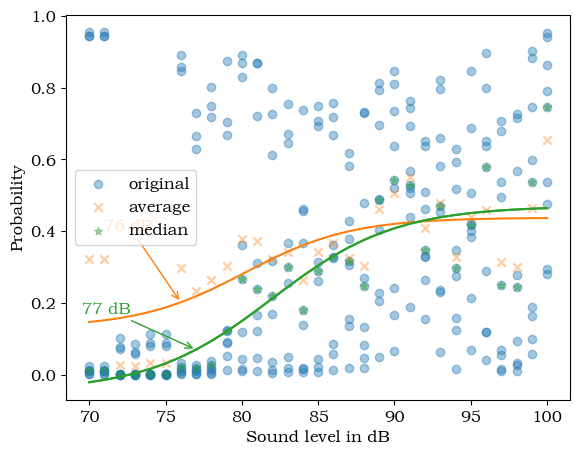

In [75]:
plot_func(colors=colors, initial_guess=initial_guess, plot_df=prob_df_LAeq)

### 使用中低年龄分组数据拟合

理想状况下，扣除对照组概率后整体数据分布会产生下移，且高年龄分组下移的程度更加明显。这里去除高年龄分组后的概率分布更加接近常识，经过拟合，可以发现确诊NIHL概率随LAeq变化的拐点在79 dB左右的位置处。

C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,
C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,


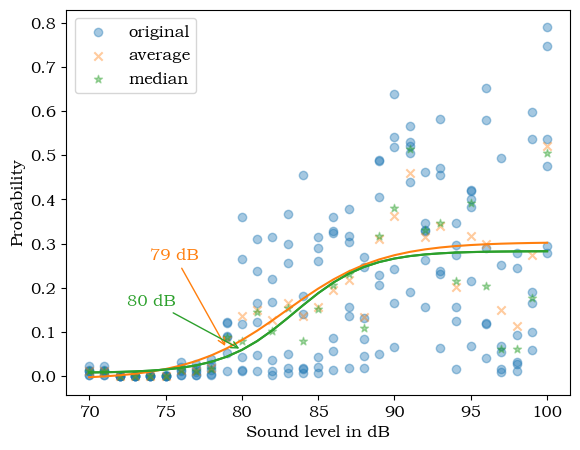

In [76]:
plot_func(colors=colors,
          initial_guess=initial_guess,
          plot_df=prob_df_LAeq.query("age_box in ('A-1', 'A-2')"))

## 校正后LAeq

对使用时域峰度的几何平均值进行校正后的LAeq作为特征训练分类模型后得到的概率分布情况进行逻辑曲线拟合，寻找随LAeq_adjust_geomean变化时确诊NIHL概率变化曲线的拐点。

In [77]:
prob_df_LAeq_adjust = pd.read_csv("./cache/LAeq_adjust_geomean-prob_df.csv",
                                  header=0)
prob_df_LAeq_adjust.head()

,LAeq,age_box,duration_box,prob
0,70,A-1,D-1,0.000313
1,71,A-1,D-1,0.000313
2,72,A-1,D-1,0.000313
3,73,A-1,D-1,0.000313
4,74,A-1,D-1,0.000551


### 使用所有年龄分组数据拟合

使用所有年龄分组数据拟合时，没有完全收敛。

值得注意的是，在高年龄分组中使用LAeq_adjust得到的概率值要比使用LAeq模型稍小一点，可能说明LAeq_adjust更优？但是目前使用LAeq的模型在分类性能上要略优于LAeq_adjust，AUC: 0.73>0.71。

C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,
d:\ProgramFiles\Anaconda\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,


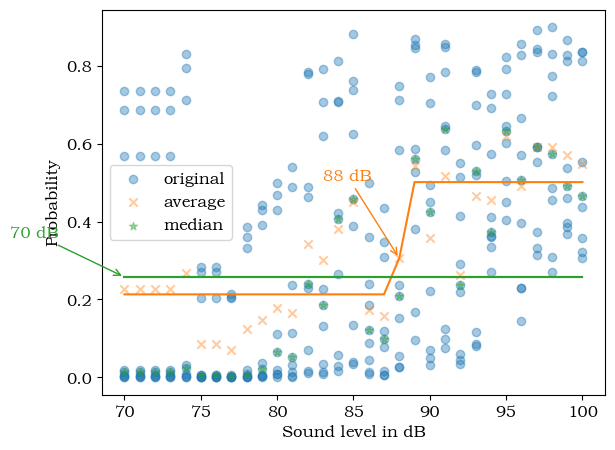

In [81]:
plot_func(colors=colors, initial_guess=initial_guess, plot_df=prob_df_LAeq_adjust)

### 使用中低年龄分组数据拟合

此时概率曲线的拐点位置到达了84 dB，比使用LAeq的增大了5 dB，主要是由于校正后LAeq_adjust增大的缘故。

C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,
C:\Users\HP\AppData\Local\Temp\ipykernel_7156\4156310357.py:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  f_prime_double = derivative(sigmoid,


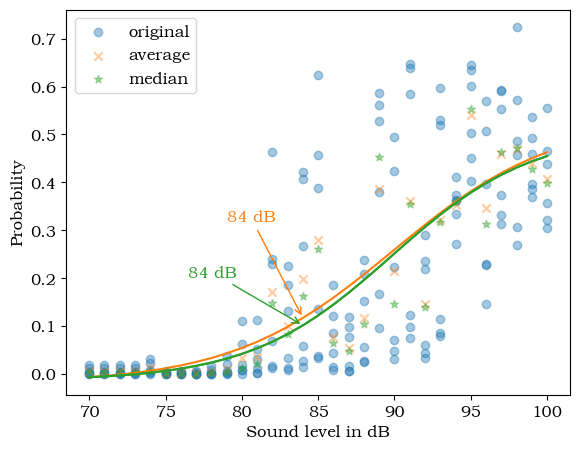

In [82]:
plot_func(colors=colors,
          initial_guess=initial_guess,
          plot_df=prob_df_LAeq_adjust.query("age_box in ('A-1', 'A-2')"))